In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install imageio-ffmpeg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 26.9 MB 1.7 MB/s 


In [ ]:
!pip install pafy youtube-dl moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 8.4 MB/s 


In [ ]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install --upgrade moviepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 388 kB 5.1 MB/s 
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110742 sha256=faae83b836bd40674ac5a4f87a5a83ed681e762270529a2c7bc6abdf86f2e3c8
  Stored in directory: /root/.cache/pip/wheels/56/dc/2b/9cd600d483c04af3353d66623056fc03faed76b7518faae4df
Successfully built moviepy
  Attempting uninstall: moviepy
    Found existing installation: moviepy 0.2.3.5
    Uninstalling moviepy-0.2.3.5:
      Successfully uninstalled moviepy-0.2.3.5


In [ ]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [ ]:
seed_constant = 5
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

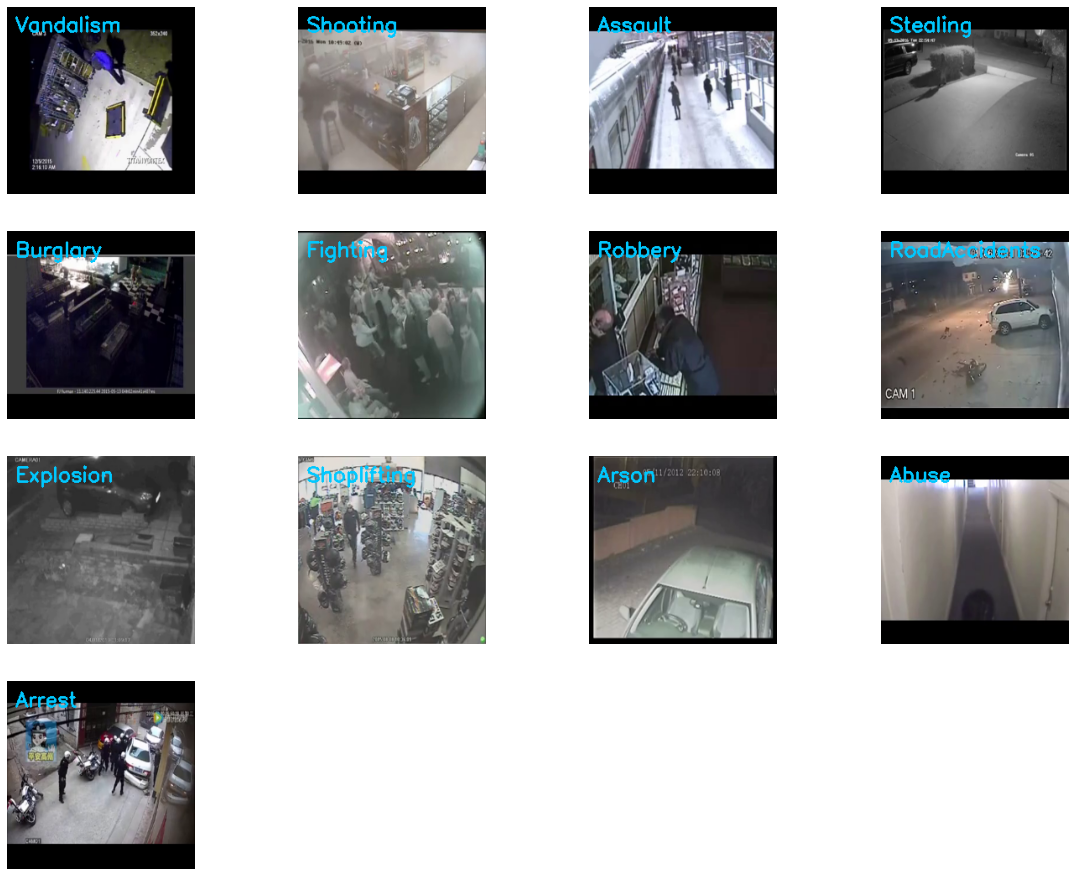

In [ ]:
plt.figure(figsize = (20, 20))

all_classes_names = os.listdir('/content/drive/MyDrive/Dataset')


for counter, random_index in enumerate(range(len(all_classes_names)), 1):
    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'/content/drive/MyDrive/Dataset/{selected_class_Name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'/content/drive/MyDrive/Dataset/{selected_class_Name}/{selected_video_file_name}')
    video_reader.set(1, 25)
    _, bgr_frame = video_reader.read()
    bgr_frame = cv2.resize(bgr_frame ,(224,224))
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 200, 255), 2)
    plt.subplot(5, 4,counter);
    plt.imshow(rgb_frame);
    plt.axis('off')

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 30
DATASET_DIR = "/content/drive/MyDrive/Dataset"
CLASSES_LIST = ["Abuse", "Arrest", "Arson","Assault","Burglary","Explosion","Fighting","RoadAccidents","Robbery","Shooting","Shoplifting","Stealing","Vandalism"]

In [ ]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list

In [ ]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
    features = np.asarray(features)
    labels = np.array(labels)
    return features, labels, video_files_paths

In [ ]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Abuse
Extracting Data of Class: Arrest
Extracting Data of Class: Arson
Extracting Data of Class: Assault
Extracting Data of Class: Burglary
Extracting Data of Class: Explosion
Extracting Data of Class: Fighting
Extracting Data of Class: RoadAccidents
Extracting Data of Class: Robbery
Extracting Data of Class: Shooting
Extracting Data of Class: Shoplifting
Extracting Data of Class: Stealing
Extracting Data of Class: Vandalism


In [ ]:
one_hot_encoded_labels = to_categorical(labels)

In [ ]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)
features = None
labels = None

In [ ]:
def create_LRCN_model():
    model = Sequential()



    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu'), input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))

    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))

    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    model.summary()

    return model

In [ ]:
model = create_LRCN_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 64, 64, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 16, 16, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 16, 16, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 4, 4, 64)     0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 4, 4, 128)    7

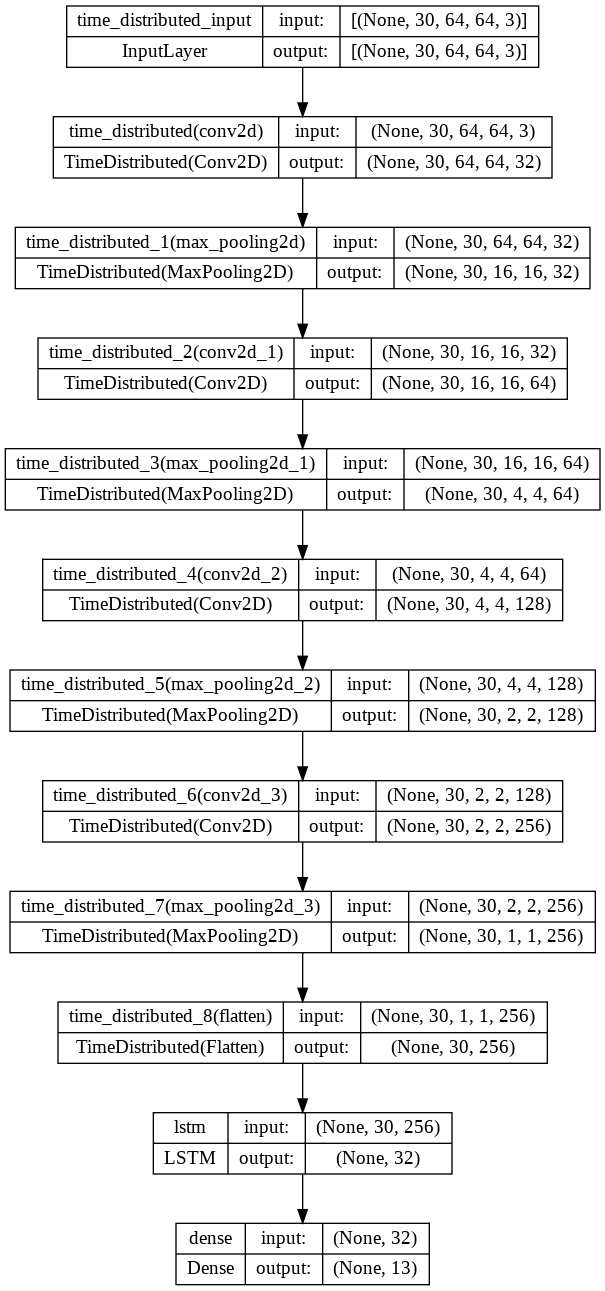

In [ ]:
plot_model(model, to_file = 'Suspicious_Human_Activity_LRCN_Model.png', show_shapes = True, show_layer_names = True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'accuracy', patience = 10, mode = 'max', restore_best_weights = True)

model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

model_training_history = model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.25, callbacks = [early_stopping_callback])

Epoch 1/70
159/159 [==============================] - 82s 497ms/step - loss: 2.5333 - accuracy: 0.1022 - val_loss: 2.4594 - val_accuracy: 0.1972
Epoch 2/70
159/159 [==============================] - 77s 485ms/step - loss: 2.4290 - accuracy: 0.1651 - val_loss: 2.3929 - val_accuracy: 0.2066
Epoch 3/70
159/159 [==============================] - 79s 499ms/step - loss: 2.2670 - accuracy: 0.2280 - val_loss: 2.3684 - val_accuracy: 0.2582
Epoch 4/70
159/159 [==============================] - 79s 496ms/step - loss: 2.1504 - accuracy: 0.2940 - val_loss: 1.9578 - val_accuracy: 0.4085
Epoch 5/70
159/159 [==============================] - 82s 514ms/step - loss: 1.8950 - accuracy: 0.3836 - val_loss: 1.8225 - val_accuracy: 0.4695
Epoch 6/70
159/159 [==============================] - 81s 510ms/step - loss: 1.7636 - accuracy: 0.4591 - val_loss: 1.6467 - val_accuracy: 0.5164
Epoch 7/70
159/159 [==============================] - 77s 487ms/step - loss: 1.4859 - accuracy: 0.5487 - val_loss: 1.4222 - val_ac

In [ ]:
model.save("Suspicious_Human_Activity_Detection_LRCN_Model.h5")

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'purple', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

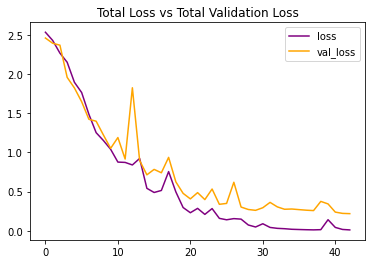

In [ ]:
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

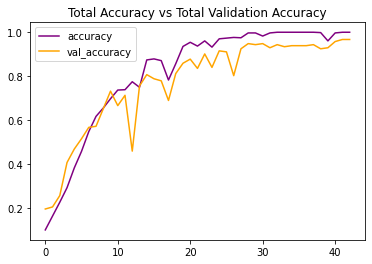

In [ ]:
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
acc = 0
for i in range(len(features_test)):
  predicted_label = np.argmax(model.predict(np.expand_dims(features_test[i],axis =0))[0])
  actual_label = np.argmax(labels_test[i])
  if predicted_label == actual_label:
      acc += 1
acc = (acc * 100)/len(labels_test)
print("Accuracy =",acc)

1/1 [==============================] - 0s 52ms/step
Accuracy = 90.49295774647888


In [ ]:
from tensorflow.keras.models import load_model
import cv2
import numpy as np
import pandas as pd
from collections import deque
from moviepy.editor import *

In [ ]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 30

DATASET_DIR = "Dataset"

CLASSES_LIST = ["Abuse", "Arrest", "Arson","Assault","Burglary","Explosion","Fighting","RoadAccidents","Robbery","Shooting","Shoplifting","Stealing","Vandalism"]

In [ ]:
model = load_model('Suspicious_Human_Activity_Detection_LRCN_Model.h5')

In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):

    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    frames_list = []

    predicted_class_name = ''

    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        success, frame = video_reader.read()

        if not success:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_list.append(normalized_frame)

    predicted_labels_probabilities = model.predict(np.expand_dims(frames_list, axis = 0))[0]

    predicted_label = np.argmax(predicted_labels_probabilities)

    predicted_class_name = CLASSES_LIST[predicted_label]

    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

    video_reader.release()

In [ ]:
predict_single_action("/content/drive/MyDrive/Dataset/Explosion/Explosion004_x264_8.mp4",SEQUENCE_LENGTH)

1/1 [==============================] - 1s 548ms/step
Action Predicted: Explosion
Confidence: 0.9930098056793213


In [ ]:
predict_single_action("/content/drive/MyDrive/Dataset/Stealing/Stealing003_x264_26.mp4",SEQUENCE_LENGTH)

1/1 [==============================] - 0s 59ms/step
Action Predicted: Stealing
Confidence: 0.9351600408554077


In [ ]:
predict_single_action("/content/drive/MyDrive/Dataset/Robbery/Robbery001_x264_13.mp4",SEQUENCE_LENGTH)

1/1 [==============================] - 0s 52ms/step
Action Predicted: Robbery
Confidence: 0.832763135433197


In [ ]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):

    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc(*'DIVX'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    predicted_class_name = ''

    while video_reader.isOpened():

        ok, frame = video_reader.read()

        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        normalized_frame = resized_frame / 255

        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = model.predict(np.expand_dims(frames_queue, axis = 0))[0]

            predicted_label = np.argmax(predicted_labels_probabilities)

            predicted_class_name = CLASSES_LIST[predicted_label]

        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

In [ ]:
%%time
predict_on_video("/content/Suspicious_Human_Activity_Detection_LRCN_Model.h5","/content/Suspicious_Human_Activity_LRCN_Model.png",SEQUENCE_LENGTH)

CPU times: user 81.8 ms, sys: 25 µs, total: 81.8 ms
Wall time: 122 ms


In [ ]:
VideoFileClip("/content/drive/MyDrive/Dataset/RoadAccidents/RoadAccidents001_x264_8.mp4", audio=False).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:   0%|          | 0/31 [00:00<?, ?it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.7/dist-packages/moviepy/video/io/ffmpeg_reader.py:130: UserWarning: Warning: in file /content/drive/MyDrive/Dataset/RoadAccidents/RoadAccidents001_x264_8.mp4, 230400 bytes wanted but 0 bytes read,at frame 30/31, at time 1.00/1.02 sec. Using the last valid frame instead.
  UserWarning)

                                                   

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
VideoFileClip("/content/drive/MyDrive/Dataset/Explosion/Explosion023_x264_22.mp4", audio=False).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:   0%|          | 0/61 [00:00<?, ?it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.7/dist-packages/moviepy/video/io/ffmpeg_reader.py:130: UserWarning: Warning: in file /content/drive/MyDrive/Dataset/Explosion/Explosion023_x264_22.mp4, 230400 bytes wanted but 0 bytes read,at frame 60/61, at time 2.00/2.02 sec. Using the last valid frame instead.
  UserWarning)

                                                   

Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
VideoFileClip("/content/drive/MyDrive/Dataset/Robbery/Robbery129_x264_18.mp4", audio=False).ipython_display()

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



t:   0%|          | 0/61 [00:00<?, ?it/s, now=None]WARNING:py.warnings:/usr/local/lib/python3.7/dist-packages/moviepy/video/io/ffmpeg_reader.py:130: UserWarning: Warning: in file /content/drive/MyDrive/Dataset/Robbery/Robbery129_x264_18.mp4, 230400 bytes wanted but 0 bytes read,at frame 60/61, at time 2.00/2.02 sec. Using the last valid frame instead.
  UserWarning)

                                                   

Moviepy - Done !
Moviepy - video ready __temp__.mp4
